In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, classification_report,
                             roc_auc_score, roc_curve)
import joblib
import warnings
warnings.filterwarnings('ignore')

print("✓ Libraries imported!")

✓ Libraries imported!


In [2]:
df = pd.read_csv('data/processed_data.csv')
X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model = joblib.load('models/trained_model.pkl')
print(f"✓ Model loaded: {type(model).__name__}")
print(f"Test samples: {X_test.shape[0]}")

✓ Model loaded: LogisticRegression
Test samples: 1409


In [3]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

print("✓ Predictions generated")

✓ Predictions generated



CONFUSION MATRIX
[[918 117]
 [174 200]]
✓ Confusion matrix saved


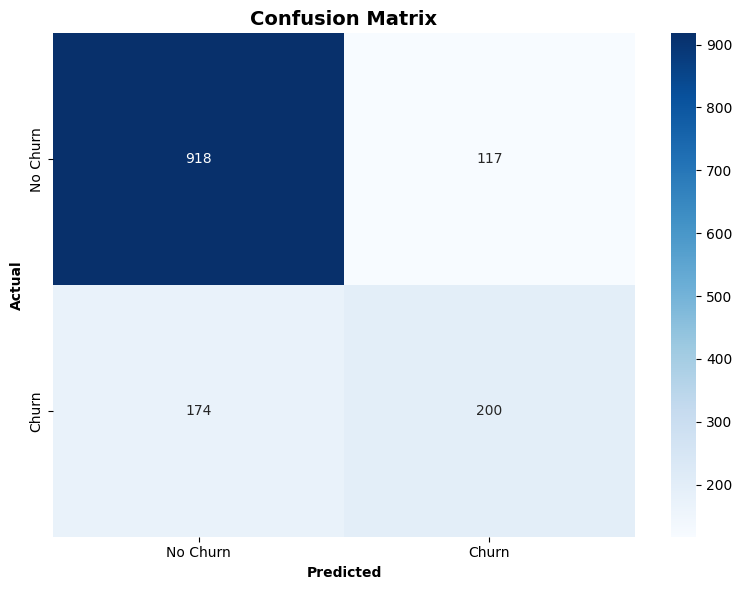

In [4]:
print(f"\n{'='*60}")
print("CONFUSION MATRIX")
print(f"{'='*60}")

cm = confusion_matrix(y_test, y_pred)
print(cm)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.ylabel('Actual', fontweight='bold')
plt.xlabel('Predicted', fontweight='bold')
plt.title('Confusion Matrix', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.savefig('data/confusion_matrix.png')
print("✓ Confusion matrix saved")
plt.show()

In [5]:
TN, FP, FN, TP = cm.ravel()

print(f"\nTrue Negatives (TN): {TN}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")
print(f"True Positives (TP): {TP}")

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"\n{'='*60}")
print("EVALUATION METRICS")
print(f"{'='*60}")
print(f"Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision: {precision:.4f} ({precision*100:.2f}%)")
print(f"Recall:    {recall:.4f} ({recall*100:.2f}%)")
print(f"F1-Score:  {f1:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}")


True Negatives (TN): 918
False Positives (FP): 117
False Negatives (FN): 174
True Positives (TP): 200

EVALUATION METRICS
Accuracy:  0.7935 (79.35%)
Precision: 0.6309 (63.09%)
Recall:    0.5348 (53.48%)
F1-Score:  0.5789
ROC-AUC:   0.8412


In [6]:
print(f"\n{'='*60}")
print("CLASSIFICATION REPORT")
print(f"{'='*60}")
print(classification_report(y_test, y_pred, 
                           target_names=['No Churn', 'Churn']))



CLASSIFICATION REPORT
              precision    recall  f1-score   support

    No Churn       0.84      0.89      0.86      1035
       Churn       0.63      0.53      0.58       374

    accuracy                           0.79      1409
   macro avg       0.74      0.71      0.72      1409
weighted avg       0.78      0.79      0.79      1409



✓ ROC curve saved


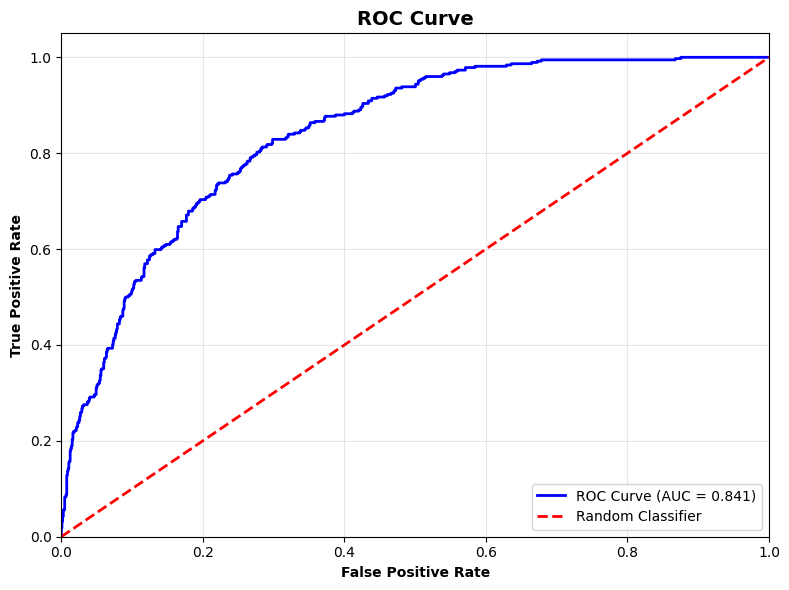

In [7]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, 
         label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontweight='bold')
plt.ylabel('True Positive Rate', fontweight='bold')
plt.title('ROC Curve', fontweight='bold', fontsize=14)
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('data/roc_curve.png')
print("✓ ROC curve saved")
plt.show()

In [8]:
print(f"\n{'='*60}")
print("HYPERPARAMETER TUNING")
print(f"{'='*60}")

from xgboost import XGBClassifier

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1.0]
}

print("Parameter grid:")
for param, values in param_grid.items():
    print(f"  {param}: {values}")

# Grid Search
print("\nStarting Grid Search (this may take a few minutes)...")
grid_search = GridSearchCV(
    XGBClassifier(eval_metric='logloss', random_state=42),
    param_grid,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)
print("✓ Grid Search complete!")



HYPERPARAMETER TUNING
Parameter grid:
  n_estimators: [100, 200]
  max_depth: [3, 5, 7]
  learning_rate: [0.01, 0.1, 0.3]
  subsample: [0.8, 1.0]

Starting Grid Search (this may take a few minutes)...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
✓ Grid Search complete!


In [10]:
print(f"\n{'='*60}")
print("BEST PARAMETERS")
print(f"{'='*60}")
print(grid_search.best_params_)

best_model = grid_search.best_estimator_
print(f"\nBest CV F1-Score: {grid_search.best_score_:.4f}")


BEST PARAMETERS
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}

Best CV F1-Score: 0.5879


In [11]:
y_pred_tuned = best_model.predict(X_test)
y_pred_proba_tuned = best_model.predict_proba(X_test)[:, 1]

accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
precision_tuned = precision_score(y_test, y_pred_tuned)
recall_tuned = recall_score(y_test, y_pred_tuned)
f1_tuned = f1_score(y_test, y_pred_tuned)
roc_auc_tuned = roc_auc_score(y_test, y_pred_proba_tuned)

print(f"\n{'='*60}")
print("TUNED MODEL PERFORMANCE")
print(f"{'='*60}")
print(f"Accuracy:  {accuracy_tuned:.4f} ({accuracy_tuned*100:.2f}%)")
print(f"Precision: {precision_tuned:.4f} ({precision_tuned*100:.2f}%)")
print(f"Recall:    {recall_tuned:.4f} ({recall_tuned*100:.2f}%)")
print(f"F1-Score:  {f1_tuned:.4f}")
print(f"ROC-AUC:   {roc_auc_tuned:.4f}")


TUNED MODEL PERFORMANCE
Accuracy:  0.8006 (80.06%)
Precision: 0.6505 (65.05%)
Recall:    0.5374 (53.74%)
F1-Score:  0.5886
ROC-AUC:   0.8407



PERFORMANCE COMPARISON
   Metric  Before Tuning  After Tuning  Improvement
 Accuracy       0.793471      0.800568     0.007097
Precision       0.630915      0.650485     0.019571
   Recall       0.534759      0.537433     0.002674
 F1-Score       0.578871      0.588580     0.009709
  ROC-AUC       0.841186      0.840701    -0.000484

✓ Comparison chart saved


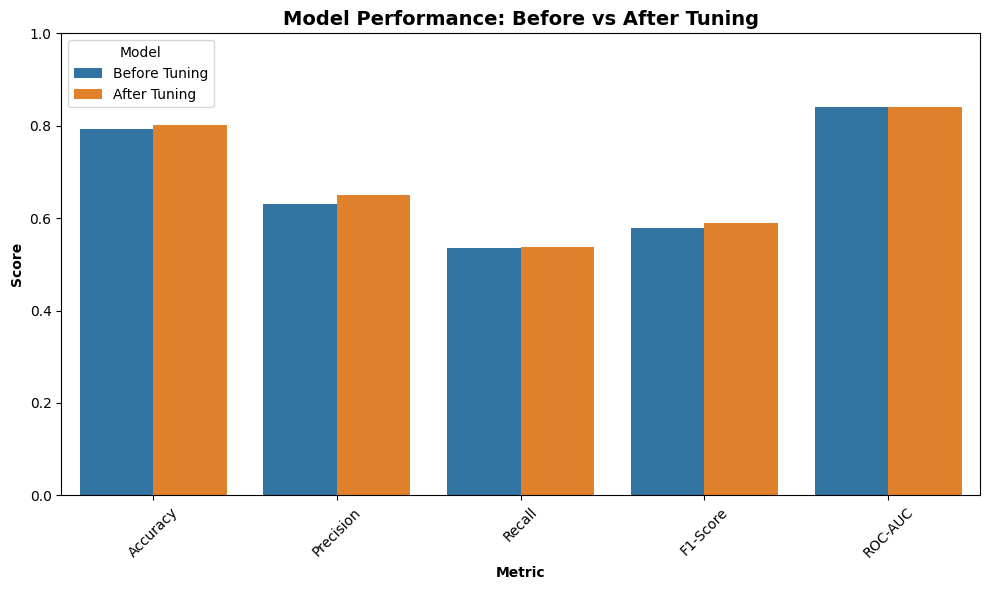

In [12]:
comparison = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'],
    'Before Tuning': [accuracy, precision, recall, f1, roc_auc],
    'After Tuning': [accuracy_tuned, precision_tuned, recall_tuned, f1_tuned, roc_auc_tuned],
})

comparison['Improvement'] = comparison['After Tuning'] - comparison['Before Tuning']

print(f"\n{'='*60}")
print("PERFORMANCE COMPARISON")
print(f"{'='*60}")
print(comparison.to_string(index=False))

# Visualize comparison
comparison_melted = comparison.melt(id_vars='Metric', 
                                    value_vars=['Before Tuning', 'After Tuning'],
                                    var_name='Model', value_name='Score')

plt.figure(figsize=(10, 6))
sns.barplot(data=comparison_melted, x='Metric', y='Score', hue='Model')
plt.ylim(0, 1)
plt.ylabel('Score', fontweight='bold')
plt.xlabel('Metric', fontweight='bold')
plt.title('Model Performance: Before vs After Tuning', fontweight='bold', fontsize=14)
plt.legend(title='Model')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('data/tuning_comparison.png')
print("\n✓ Comparison chart saved")
plt.show()

In [13]:
joblib.dump(best_model, 'models/final_model.pkl')
print("\n✓ Final tuned model saved to 'models/final_model.pkl'")


✓ Final tuned model saved to 'models/final_model.pkl'


In [14]:
evaluation_results = {
    'accuracy': accuracy_tuned,
    'precision': precision_tuned,
    'recall': recall_tuned,
    'f1_score': f1_tuned,
    'roc_auc': roc_auc_tuned,
    'best_params': str(grid_search.best_params_)
}

pd.DataFrame([evaluation_results]).to_csv('data/evaluation_results.csv', index=False)
print("✓ Evaluation results saved")

✓ Evaluation results saved


In [15]:
print(f"\n{'='*60}")
print("EVALUATION & TUNING COMPLETE")
print(f"{'='*60}")
print(f"Final Model Performance:")
print(f"  - Accuracy:  {accuracy_tuned*100:.2f}%")
print(f"  - Recall:    {recall_tuned*100:.2f}% (catches {recall_tuned*100:.0f}% of churners)")
print(f"  - F1-Score:  {f1_tuned:.3f}")
print(f"\nModel is ready for deployment!")
print(f"{'='*60}")


EVALUATION & TUNING COMPLETE
Final Model Performance:
  - Accuracy:  80.06%
  - Recall:    53.74% (catches 54% of churners)
  - F1-Score:  0.589

Model is ready for deployment!
